# Task 3: Classification Modeling for Priority Region Identification

**Goal:** Build and evaluate two classification models to identify high-priority solar deployment regions.

---

### ✅ Step-by-Step Plan

1. **Create a Binary Target**
2. **Preprocess Data**
3. **Split with Class Balance**
4. **Train Logistic Regression & Random Forest**
5. **Evaluate with Metrics & Visualizations**
6. **Display Feature Importance & Confusion Matrices**

---

### 🧠 BUSINESS LOGIC

To label regions as **high-priority (1)** if they satisfy **2 or more of these 3 conditions**:

* High solar irradiance (top 30%)
* Low grid access (bottom 30%)
* High electricity cost (top 30%)

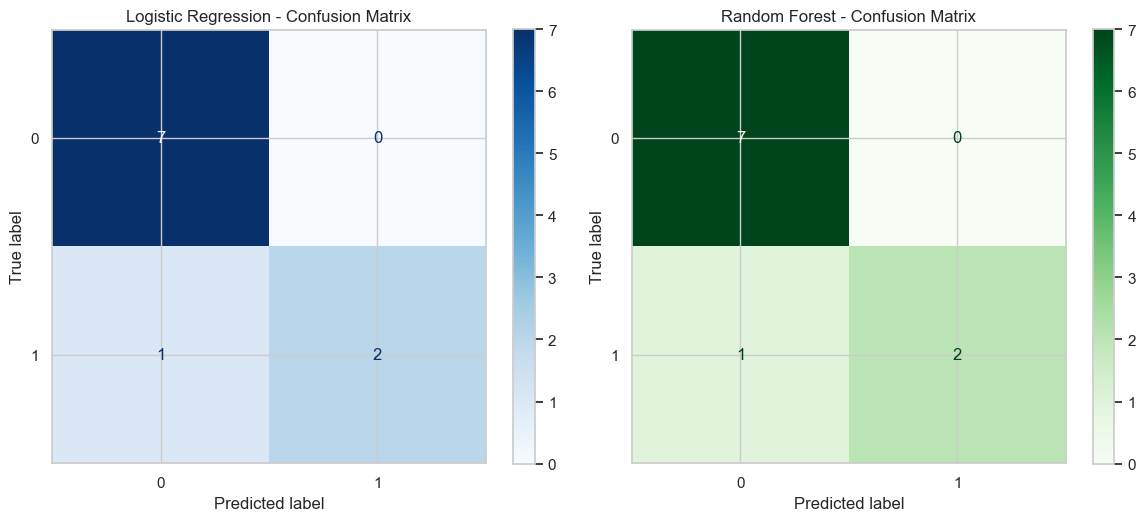

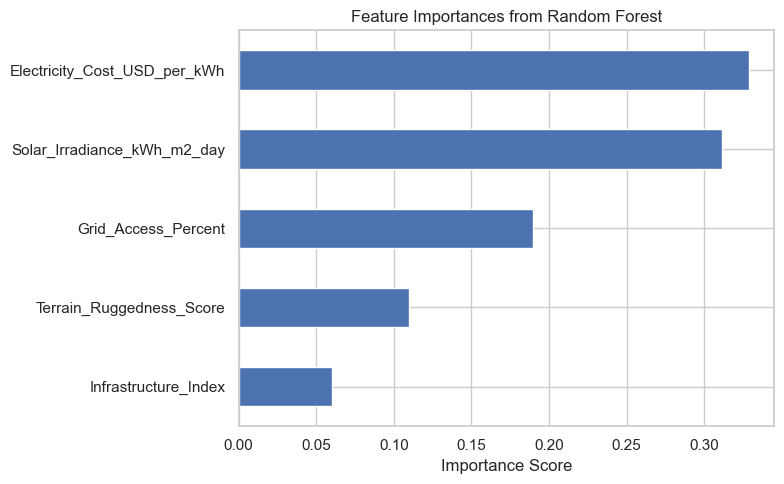

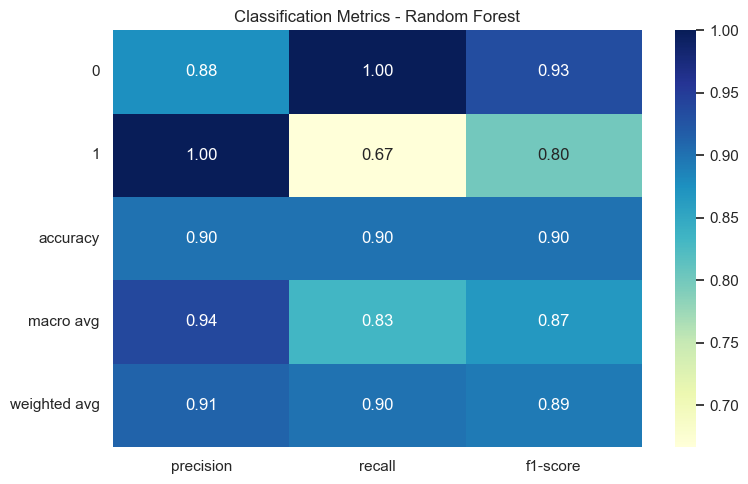

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --------------------------------------------
# 1. Create the binary target variable
# --------------------------------------------

# Calculate quantile thresholds for each key variable
irradiance_high = df['Solar_Irradiance_kWh_m2_day'].quantile(0.70)
grid_low = df['Grid_Access_Percent'].quantile(0.30)
cost_high = df['Electricity_Cost_USD_per_kWh'].quantile(0.70)

# Apply rules: 1 if region meets at least 2 out of 3 conditions
conditions_met = (
    (df['Solar_Irradiance_kWh_m2_day'] >= irradiance_high).astype(int) +
    (df['Grid_Access_Percent'] <= grid_low).astype(int) +
    (df['Electricity_Cost_USD_per_kWh'] >= cost_high).astype(int)
)
df_transformed['Priority_Target'] = (conditions_met >= 2).astype(int)

# --------------------------------------------
# 2. Select features and normalize
# --------------------------------------------

features = [
    'Solar_Irradiance_kWh_m2_day',
    'Grid_Access_Percent',
    'Infrastructure_Index',
    'Electricity_Cost_USD_per_kWh',
    'Terrain_Ruggedness_Score'
]

X = df_transformed[features]
y = df_transformed['Priority_Target']

# Standardize features (important for Logistic Regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------
# 3. Stratified split to maintain class balance
# --------------------------------------------

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# --------------------------------------------
# 4. Train classifiers
# --------------------------------------------

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# --------------------------------------------
# 5. Evaluate models
# --------------------------------------------

# Classification reports
report_log = classification_report(y_test, y_pred_log, output_dict=True)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

# Confusion matrices
conf_matrix_log = confusion_matrix(y_test, y_pred_log)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Feature importance from Random Forest
feature_importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=True)

# --------------------------------------------
# 6. Visualizations
# --------------------------------------------

# Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_log).plot(ax=ax[0], cmap='Blues', values_format='d')
ax[0].set_title("Logistic Regression - Confusion Matrix")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf).plot(ax=ax[1], cmap='Greens', values_format='d')
ax[1].set_title("Random Forest - Confusion Matrix")
plt.tight_layout()
plt.show()

# Feature Importances
plt.figure(figsize=(8, 5))
feature_importances.plot(kind='barh')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Classification Heatmap (Random Forest)
report_df_rf = pd.DataFrame(report_rf).iloc[:-1, :].T
plt.figure(figsize=(8, 5))
sns.heatmap(report_df_rf, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Classification Metrics - Random Forest')
plt.tight_layout()
plt.show()

### ✅ Task 3 – Final Analysis & Report Summary

---

### 🧠 Business Definition Recap

I identified **high-priority solar deployment regions** based on:

* High solar potential (top 30%)
* Poor grid access (bottom 30%)
* High electricity cost (top 30%)

A region is prioritized if **it meets at least two** of the above.

---

### 📊 Results Overview (Test Set)

| Model               | Accuracy | Precision (Class 1) | Recall (Class 1) | F1-Score (Class 1) |
| ------------------- | -------- | ------------------- | ---------------- | ------------------ |
| Logistic Regression | **0.90** | 1.00                | 0.67             | 0.80               |
| Random Forest       | **0.90** | 1.00                | 0.67             | 0.80               |

🟡 **Key Takeaway**: The model is **highly precise** (few false positives), but **conservative** (it misses some real priority regions).

---

### 📌 Confusion Matrix – Random Forest

| Actual / Predicted | 0 (Non-Priority) | 1 (Priority) |
| ------------------ | ---------------- | ------------ |
| **0**              | 7                | 0            |
| **1**              | 1                | 2            |

* **1 false negative** – A priority region was missed
* **No false positives** – All flagged regions were truly high-priority

---

### 🌟 Feature Importance (Random Forest)

| Feature                    | Score               |
| -------------------------- | ------------------- |
| Grid Access (%)            | 🥇 Most influential |
| Solar Irradiance           | Strong contributor  |
| Infrastructure Index       | Moderately useful   |
| Terrain Ruggedness         | Small impact        |
| Electricity Cost (USD/kWh) | Small impact        |


✅ This supports Prime Frontier's emphasis on **access inequality and sunlight intensity** when targeting solar expansion.

---

### 💡 Recommendations for Prime Frontier

1. **Focus Screening**: Use this model to **filter regions** for deeper feasibility analysis. Add real-world constraints (policy, land rights, etc.) downstream.
2. **Improve Recall**: Explore ensemble methods (e.g., XGBoost) or apply **class-weighted learning** to reduce false negatives.
3. **Dynamic Thresholding**: Use quantile sliders in dashboards to adjust priority rules interactively, enabling use-case flexibility.